## DGMD S-17 Robotics, Autonomous Vehicles, Drones, and Artificial Intelligence

### Object Detection, Depth Perception and Adaptive Navigation with a Tello Drone

### Group Members: Ryan Abbate, Eumar Assis, Muthukaruppan (Muthu) Annamalai

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import title

## Load Telemetry data frame

In [6]:
#Load Telemetry Data File - First Version
df = pd.read_csv("../assets/telemetry.csv")

df["version"] = "1"

#Load Telemetry Data File - Second Version (color intensity only for bounding boxes)
df_v2 = pd.read_csv("../assets/telemetry_v2.csv")

df_v2["version"] = "2"

# Merge two data frames
df = pd.concat([df, df_v2], axis=0)

#Rename Columns
if not 'total_intensity' in list(df.columns):
    df_c = df[df['Model'] == 'DepthPerception'][['log_time', 'confidence']].rename(columns={'log_time': 'log_time', 'confidence': 'total_intensity'})
    df = pd.merge(df, df_c, on='log_time')

# DepthPerception does not provide confidence level
df.loc[df['Model'] == 'DepthPerception', 'confidence'] = 0

# Only DepthPerception should have confidence level
df.loc[df['Model'] != 'DepthPerception', 'total_intensity'] = 0

# filters the data to extract YOLO and Azure object detection models for comparision
df_object_detect = df[df['Model'].isin(['YOLOObjectDetector', 'AzureObjectDetector'])]

# filters the data to extract YOLO object YOLO face detection models for comparision
df_yolo_detect = df[df['Model'].isin(['YOLOObjectDetector', 'YOLOFaceDetector'])]

df_depth_estimation = df[df['Model'].isin(['DepthPerception'])]

# filters the data to extract all detection models for comparision
df_all_detect = df[df['Model'].isin(['YOLOObjectDetector', 'YOLOFaceDetector', 'AzureObjectDetector'])].copy()

# adds a column for bounding box height
df_all_detect['bounding_box_size'] = df_all_detect['detected bounding box width'] * df_all_detect['detected bounding box height']

print(df.columns)
# df.describe()
df

Index(['log_time', 'Model', 'confidence', 'detected bounding box width',
       'detected bounding box height', 'img xcenter', 'img ycenter',
       'model output xcenter', 'model output ycenter',
       'height (distance to floor)', 'is_flying', 'version',
       'total_intensity'],
      dtype='object')


,log_time,Model,confidence,detected bounding box width,detected bounding box height,img xcenter,img ycenter,model output xcenter,model output ycenter,height (distance to floor),is_flying,version,total_intensity
0,2022-08-02 12:17:20.532976,YOLOObjectDetector,0.692772,676.316956,555.245911,480.0,360.0,519.071777,433.902924,0,False,1,0.0
1,2022-08-02 12:17:20.532976,DepthPerception,0.000000,NaN,NaN,480.0,360.0,NaN,NaN,0,False,1,243017952.0
2,2022-08-02 12:17:20.532976,AzureObjectDetector,0.920000,604.000000,560.000000,480.0,360.0,97.500000,76.000000,0,False,1,0.0
3,2022-08-02 12:22:13.813549,YOLOFaceDetector,0.947042,229.000000,377.000000,480.0,360.0,179.500000,-3.000000,0,False,1,0.0
4,2022-08-02 12:22:13.813549,YOLOObjectDetector,0.586069,913.993164,718.340942,480.0,360.0,492.926575,360.829529,0,False,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,2022-08-03 14:43:27.359103,AzureObjectDetector,0.872000,452.000000,390.000000,480.0,360.0,55.500000,162.500000,0,False,2,0.0
731,2022-08-03 14:43:33.735441,YOLOFaceDetector,0.572569,140.000000,170.000000,480.0,360.0,183.500000,199.500000,0,False,2,0.0
732,2022-08-03 14:43:33.735441,YOLOObjectDetector,0.775029,451.402649,367.198425,480.0,360.0,321.185455,535.024902,0,False,2,0.0
733,2022-08-03 14:43:33.735441,DepthPerception,0.000000,NaN,NaN,480.0,360.0,NaN,NaN,0,False,2,10253911.0


## 1. Comparing Azure vs. YOLO 

Comparing people detector models

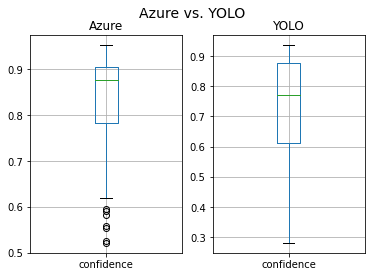

In [7]:
#Get filtered data frames
azure_df = df[df['Model'] =='AzureObjectDetector'] 

yolo_df = df[df['Model'] == 'YOLOObjectDetector']

# Plot two histograms side by side using Matplotlib
fig, axes = plt.subplots(1, 2)

fig.suptitle('Azure vs. YOLO', fontsize=14)

azure_df.boxplot('confidence', ax=axes[0])
axes[0].set_title('Azure')
yolo_df.boxplot('confidence', ax=axes[1])
axes[1].set_title('YOLO')
plt.show()



## 2. Comparing YOLO Face vs. YOLO

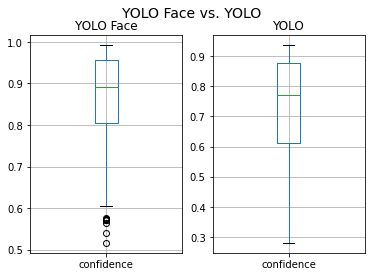

In [8]:
#Get filtered data frames
yolo_face_df = df[df['Model'] == 'YOLOFaceDetector']

# Plot two histograms side by side using Matplotlib
fig, axes = plt.subplots(1, 2)
fig.suptitle('YOLO Face vs. YOLO', fontsize=14)
yolo_face_df.boxplot('confidence', ax=axes[0])
axes[0].set_title('YOLO Face')
yolo_df.boxplot('confidence', ax=axes[1])
axes[1].set_title('YOLO')
plt.show()

## 3. Model Accuracy Histogram

Comparing accuracy of 1. YOLO, 2. YOLO Face & 3. Azure Models

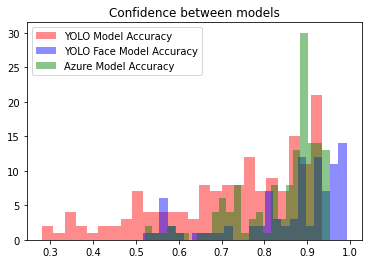

In [9]:
# plotting two histograms on the same axis
plt.hist(yolo_df['confidence'], bins=25, alpha=0.45, color='red')
plt.hist(yolo_face_df['confidence'], bins=25, alpha=0.45, color='blue')
plt.hist(azure_df['confidence'], bins=25, alpha=0.45, color='green')

plt.title("Confidence between models")
plt.legend(['YOLO Model Accuracy',
            'YOLO Face Model Accuracy',
            'Azure Model Accuracy'])
  
plt.show()

## 4. Box / Swarm Plots of YOLO vs. Azure

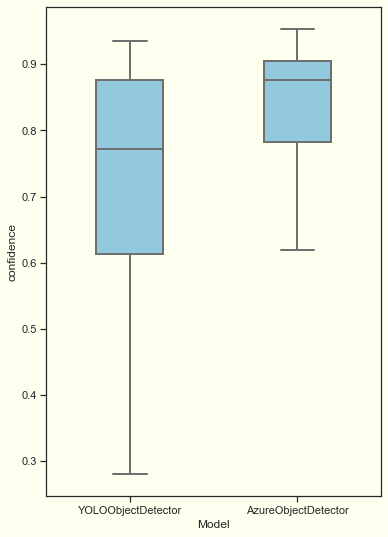

In [10]:
# adds styling
sns.set(style = 'ticks',
        rc={'figure.figsize' : (6, 9),
            'figure.facecolor' : 'ivory',
            'axes.facecolor' : 'ivory'
           })

ax_1 = sns.boxplot(data = df_object_detect,
                x = 'Model',
                y = 'confidence',
                width = 0.4,
                color = 'skyblue',
                linewidth = 2,
                showfliers = False
                )

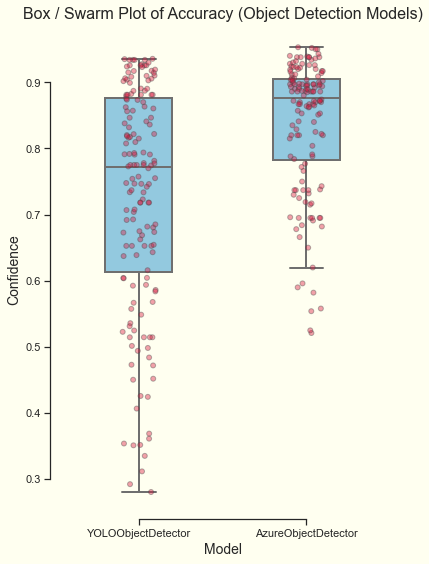

In [11]:
sns.stripplot(data = df_object_detect,
                  x = 'Model',
                  y = 'confidence',
                  color = 'crimson',
                  linewidth = 1,
                  alpha = 0.4,
                  ax = ax_1)

# adds titles and removes the spine
ax_1.set_ylabel('Confidence', fontsize = 14)
ax_1.set_xlabel('Model', fontsize = 14)
ax_1.set_title('Box / Swarm Plot of Accuracy (Object Detection Models)', fontsize = 16)
sns.despine(offset = 5, trim = True, ax = ax_1)

# renders the plot
a = ax_1.get_figure()

# saves plot
# a.savefig('box_swarm_object_dectect_accuracy.png', dpi = 1000)
a

## 5. Box / Swarm Plots of YOLO Models

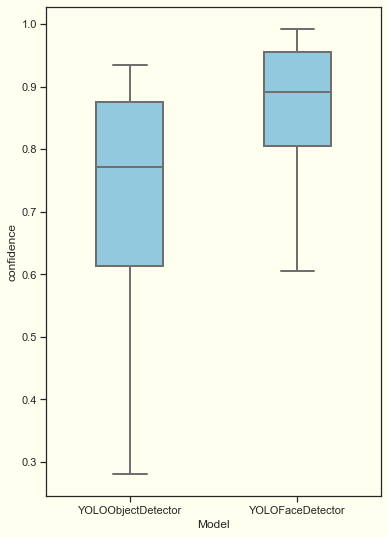

In [12]:
ax_2 = sns.boxplot(data = df_yolo_detect,
                x = 'Model',
                y = 'confidence',
                width = 0.4,
                color = 'skyblue',
                linewidth = 2,
                showfliers = False
                )

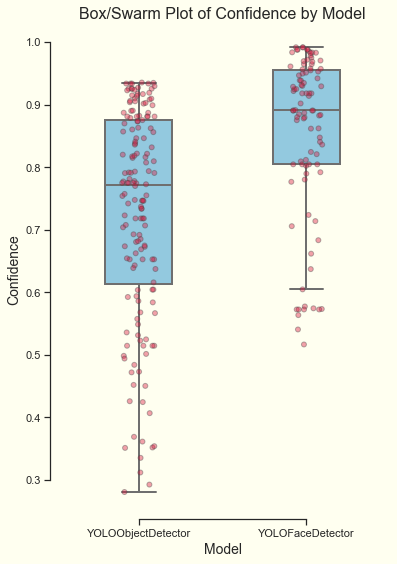

In [13]:
sns.stripplot(data = df_yolo_detect,
                  x = 'Model',
                  y = 'confidence',
                  color = 'crimson',
                  linewidth = 1,
                  alpha = 0.4,
                  ax = ax_2)

# adds titles and removes the spine
ax_2.set_ylabel('Confidence', fontsize = 14)
ax_2.set_xlabel('Model', fontsize = 14)
ax_2.set_title('Box/Swarm Plot of Confidence by Model', fontsize = 16)
sns.despine(offset = 5, trim = True, ax = ax_2)

b = ax_2.get_figure()
# b.savefig('box_swarm_face_dectect_accuracy.png', dpi = 1000)
b

## 6. Histograms of Accuracy for Detection Models

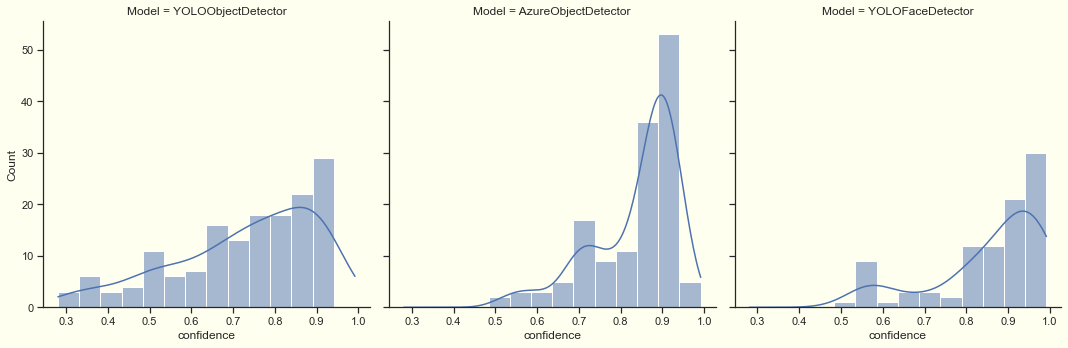

In [14]:
d = sns.displot(data=df_all_detect, kind='hist', kde=True,
            x='confidence', col='Model'
            )
# d.savefig('hist_detection_models.png', dpi = 1000)

## 7. Scatter Plots of Accuracy ~ Bounding Box Size

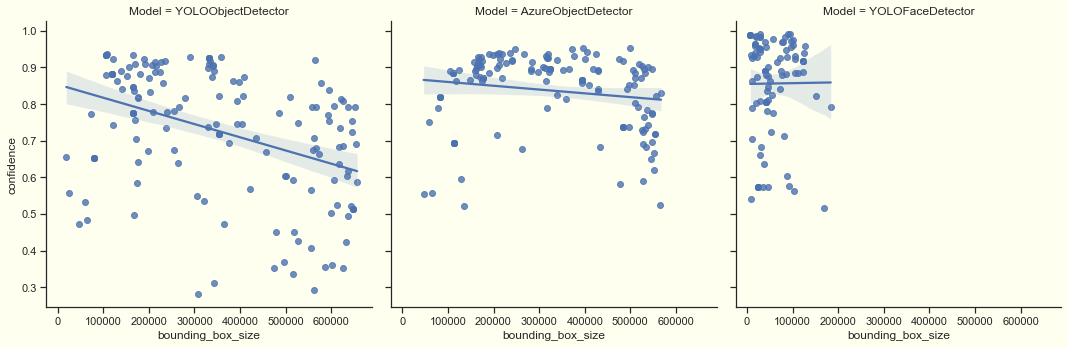

In [38]:
f = sns.lmplot(data = df_all_detect,
            col = 'Model', 
            x = 'bounding_box_size', 
            y = 'confidence')

## 8. Finding Distance from the camera using correlation between Color Density vs. Bounding Box Sizes

Results indicate some level of correlation:

 - 25% positive correlation between color density and bounding box size when using the entire image.
 - 36% positive correlation between color density and bounding box size when using only the detected face's bounding box for color density.

Therefore, we can combine these two metrics to measure user distance from the camera.


Text(0.5, 1.0, 'Version 2: Face Only')

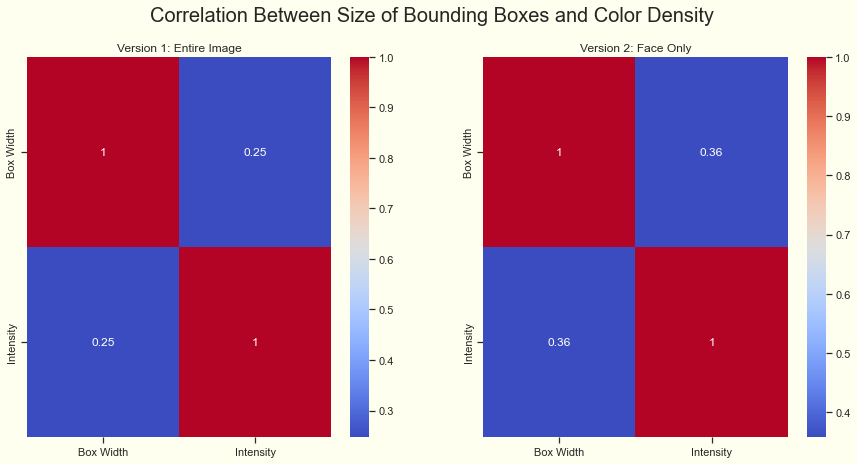

In [17]:

df_comparing_model = df[df['Model'].isin(['YOLOFaceDetector', 'DepthPerception' ])]

#Group by timestamp to keep results from both models in one row (collapse)
df_comparing_model_v1 = df[df['version'] == '1'].groupby("log_time").mean()[['detected bounding box width', 'total_intensity']]

df_comparing_model_v2 = df[df['version'] == '2'].groupby("log_time").mean()[['detected bounding box width', 'total_intensity']]

df_comparing_model_v1 = df_comparing_model_v1.rename(columns = {'detected bounding box width' : 'Box Width',
                                                      'total_intensity' : 'Intensity',
                                                      })

df_comparing_model_v2 = df_comparing_model_v2.rename(columns = {'detected bounding box width' : 'Box Width',
                                                      'total_intensity' : 'Intensity',
                                                      })

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

fig.suptitle('Correlation Between Size of Bounding Boxes and Color Density', fontsize=20)

sns.heatmap(df_comparing_model_v1.corr(), ax=axs[0], annot = True, fmt='.2g',cmap= 'coolwarm')
sns.heatmap(df_comparing_model_v2.corr(), ax=axs[1], annot = True, fmt='.2g',cmap= 'coolwarm')

axs[0].set_title("Version 1: Entire Image")
axs[1].set_title("Version 2: Face Only")